# Examples

Let's go over some quick examples of how you might use ``pypbomb`` to design a detonation tube for your research.

In [1]:
from itertools import product

import cantera as ct
import pandas as pd
import pint
import seaborn as sns

from pypbomb import tube

ureg = pint.UnitRegistry()
quant = ureg.Quantity

## Determine tube size and operating limits

First we will pick a mixture of stoichiometric propane/air. For this example we will use ``gri30.cti`` as the mechanism of choice for our Cantera calculations.

In [2]:
fuel = "C3H8"
oxidizer = "O2:1 N2:3.76"
material = "316L"
mechanism = "gri30.cti"
gas = ct.Solution(mechanism)
gas.set_equivalence_ratio(1, fuel, oxidizer)

Next, let's consider 316L since it's a commonly used stainless steel.

In [3]:
material = "316L"

At this point we should probably out which schedules are available across all of the potential pipe sizes that we'd like to consider.

In [4]:
potential_sizes = ["4", "6", "8"]
common_sizes = set(tube.Tube.get_available_pipe_schedules(potential_sizes[0]))
for size in potential_sizes[1:]:
    common_sizes.intersection_update(
        set(tube.Tube.get_available_pipe_schedules(size))
    )
common_sizes

{'10', '10s', '120', '160', '40', '40s', '5', '5s', '80', '80s', 'XXH'}

Given these options, let's choose schedules 40, 80, 120, and XXH for consideration.

In [5]:
potential_schedules = ["40", "80", "120", "XXH"]

Let's also look at a couple of different operating temperatures. Room temperature is always a good place to start. We will also look at 100 degrees Celsius; perhaps we want to use a hot water jacket to investigate detonations at elevated initial temperatures, so let's use 100 degrees as well.

In [6]:
initial_temperatures = [
    quant(20, "degC"),
    quant(100, "degC"),
]

Now let's figure out what we can do with each combination of pipe size, pipe schedule, and initial temperature. The steps we will use for each combination are:

1. look up the tube dimensions,
2. look up the maximum allowable stress,
3. calculate the corresponding maximum pressure,
4. look up the elastic modulus, density, and Poisson ratio of our tube material, and
5. calculate the maximum safe initial pressure that we can test at.

Note that we are setting ``multiprocessing=False``, since multiprocessing can cause unexpected misbehavior when run from within a jupyter notebook.

In [7]:
combinations = list(
    product(
        potential_schedules,
        potential_sizes,
        initial_temperatures
    )
)
results = pd.DataFrame(
    columns=[
        "schedule",
        "size",
        "initial pressure (kPa)",
        "initial temperature (K)"
    ]
)
for i, (schedule, size, initial_temperature) in enumerate(combinations):
    dims = tube.Tube.get_dimensions(
        size,
        schedule,
        unit_registry=ureg
    )
    max_stress = tube.Tube.calculate_max_stress(
        initial_temperature,
        material,
        welded=False,
        unit_registry=ureg
    )
    max_pressure = tube.Tube.calculate_max_pressure(
        dims["inner_diameter"],
        dims["outer_diameter"],
        max_stress
    )
    elastic_modulus = tube.Tube.get_elastic_modulus(material, ureg)
    density = tube.Tube.get_density(material, ureg)
    poisson = tube.Tube.get_poisson(material)
    initial_pressure = tube.Tube.calculate_max_initial_pressure(
        dims["inner_diameter"],
        dims["outer_diameter"],
        initial_temperature,
        gas.mole_fraction_dict(),
        mechanism,
        max_pressure.to("Pa"),
        elastic_modulus,
        density,
        poisson,
        use_multiprocessing=False
    )

    current_results = pd.Series(dtype="object")
    current_results["schedule"] = schedule
    current_results["size"] = size
    current_results["initial pressure (kPa)"] = \
    initial_pressure.to("kPa").magnitude
    current_results["initial temperature (K)"] = \
        initial_temperature.to("K").magnitude
    results = pd.concat((results, current_results.to_frame().T))

o wow do the plot thign cool

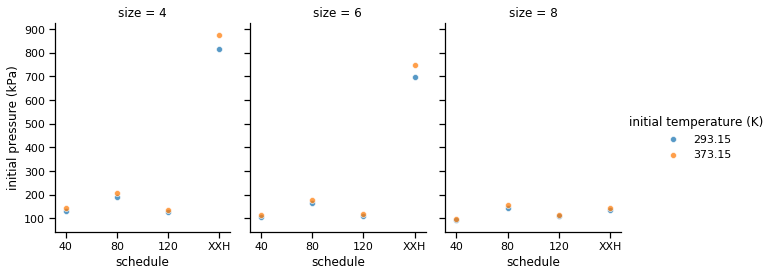

In [8]:
sns.set_context("notebook")
g = sns.FacetGrid(
    col="size",
    hue="initial temperature (K)",
    data=results,
    height=4,
    aspect=0.75,
)
g.map(
    sns.scatterplot,
    "schedule",
    "initial pressure (kPa)",
    alpha=0.75,
).add_legend()
sns.despine()
